In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

In [2]:
import numpy
def ode_solve(z0, t0, t1, f):#t0 & t1 are not scolar?
#    print(t0, t1)
    t_array = torch.linspace(t0[0,0], t1[0,0], steps=101)
    z = z0
    for t, h in zip(t_array[1:], t_array[1:]-t_array[:-1]):
        z = z + h*f(z, t)
    return z

ode_solve(torch.tensor([0.,1.,2.]), torch.tensor([[0]]), torch.tensor([[1]]), lambda x,t : x)

tensor([0.0000, 2.7048, 5.4096])

In [3]:
import torch
from torch import nn
from torch import Tensor
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, a):
        """
        Compute f, adf/dz, adf/dp(parameter:theta) & adf/dt
        Args:
            - z:
                - shape:(batch_size, )
            - t:
            - a: adjoint
                - the length of `graph_outputs` should match the length of `outputs`
                    >[Automatic differentiation package \- torch\.autograd — PyTorch master documentation](https://pytorch.org/docs/stable/autograd.html)
        """
        batch_size = z.shape[0]
        
        #calc forward propagation
        out = self.forward(z, t)
        #calc backward propagation
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,),
            (z, t) + tuple(self.parameters()),
            grad_outputs=(a,),
            allow_unused=True,
            retain_graph=True,
        )
        #expand adfdp
        #[adfdps_of_parameter1, adfdps_of_parameter2,...] -> [*adfdp_in_batch1, *adfdp_in_batch2,...]/batchsize
        if adfdp is not None:
            adfdp = torch.cat([grad_about_a_parameter.flatten() for grad_about_a_parameter in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size#-1 should be the number of parameters
        #expand adfdt
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size

        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [4]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [5]:
class ODEAdjoint(torch.autograd.Function):
    """
    Custom autograd function for neural ode
    """
    @staticmethod
    def forward(context, z0, t, flat_parameters, func):
        """
        underconstruction
        Args:
            context:
            z0:
            t (torch.Tensor): like torch.Tensor([0, 1])
            flat_parameters:return of `ODEF.flatten_parameters()`
            func (ODEF):
        Return:
            torch.Tensor: whole z 
        Examples:
            
        """
        assert isinstance(func, ODEF)#To avoid emerge type error only in backword()
        
        batch_size, *z_shape = z0.size()
        #???
        with torch.no_grad():
            z = torch.zeros(len(t), batch_size, *z_shape).to(z0)#make same type array & use same device
            z[0] = z0
            #This line does only allocate memory explicitly?
            for i in range(len(t)-1):
#                z[i+1] = ode_solve(z[i], t[i], t[i+1], func)
                z0 = ode_solve(z0, t[i], t[i+1], func)
                z[i+1] = z0

        #save states for backward
        context.func = func
        context.save_for_backward(
            t,
            z.clone(),#why take copy?
            flat_parameters,
        )
        
        return z
    
    @staticmethod
    def backward(context, dLdz):
        """

        Args:
            dLdz (torch.Tensor):
                dLdz.shape: len(t), batch_size, *z_shape
        """
        func = context.func
        t, z, flat_parameters = context.saved_tensors
        _, batch_size, *z_shape = z.size()
        number_of_dimension = numpy.prod(z_shape)
        number_of_parameters = len(flat_parameters)

        def augmented_dynamics(aug_z_i, t_i):
            """
            Dynamics of augmented system t obe calculated backwards in time
            Args:
                arg_z_i (torch.Tensor): torch.cat(z_i, a, )
            """
            z_i, a = aug_z_i[:, :number_of_dimension], aug_z_i[:, number_of_dimension:2*number_of_dimension]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(batch_size, *z_shape)
            a = a.view(batch_size, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(batch_size, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(batch_size, number_of_parameters).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(batch_size, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(batch_size, number_of_dimension)
            adfdz = adfdz.view(batch_size, number_of_dimension)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)
        
        dLdz = dLdz.view(len(t), batch_size, number_of_dimension)#flatten for convinience
        with torch.no_grad():
            adjoint_z = torch.zeros(batch_size, number_of_dimension).to(dLdz)
            adjoint_p = torch.zeros(batch_size, number_of_parameters).to(dLdz)
            adjoint_t = torch.zeros(len(t), batch_size, 1).to(dLdz)
            
            for i in reversed(range(1, len(t))):# i in [batch_size, ..., 1]
                f_i = func(z[i], t[i]).view(batch_size, number_of_dimension)#flatten f_i
                dLdz_i = torch.bmm(#(a*b).sum()
                    dLdz[i].unsqueeze(-1).transpose(1, 2),#(batch_size, 1, number_of_dimension)
                    f_i.unsqueeze(-1)#(batch_size, number_of_dimension, 1)
                )[:, 0]#(batch_size, 1, 1)--[:, 0]->(batch_size, 1)

                #Adjusting adjoints with direct gradients (using Euler method?)
                adjoint_z += dLdz_i
                adjoint_t[i] -= dLdz_i
                
                #solve augmented system backward
                augmented_z = torch.cat(
                    (
                        z[i].view(batch_size, number_of_dimension),
                        adjoint_z,
                        torch.zeros(batch_size, number_of_parameters).to(z),
                        adjoint_t[i],
                    ),
                    dim=-1
                )
                augmented_answer = ode_solve(augmented_z, t[i], t[i-1], augmented_dynamics)
                adjoint_z[:] = augmented_answer[:, number_of_dimension:2*number_of_dimension]
                adjoint_p[:] += augmented_answer[:, 2*number_of_dimension:2*number_of_dimension + number_of_parameters]
                adjoint_t[i-1] = augmented_answer[:, 2*number_of_dimension + number_of_parameters:]
                
                #del augmented_z, augmented_answer
            #Adjust t=0 adjoint with direct gradients (using Euler method?)
            dLdz_0 = torch.bmm(
                dLdz[0].unsqueeze(-1).transpose(1, 2),
#                func(z[0], t[0]).view(batch_size, number_of_dimension).unsqueeze(-1),#f_i.unsqueeze(-1)???
                f_i.unsqueeze(-1),
            )[:, 0]
            adjoint_z += dLdz_0
            adjoint_t[0] -= dLdz_0
        return adjoint_z.view(batch_size, *z_shape), adjoint_t, adjoint_p, None#why return additional None?

In [6]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [7]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [8]:
def to_np(x):
    return x.detach().cpu().numpy()
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None:
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"assets/imgs/{name}/{i}.png")
            clear_output(wait=True)

In [9]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

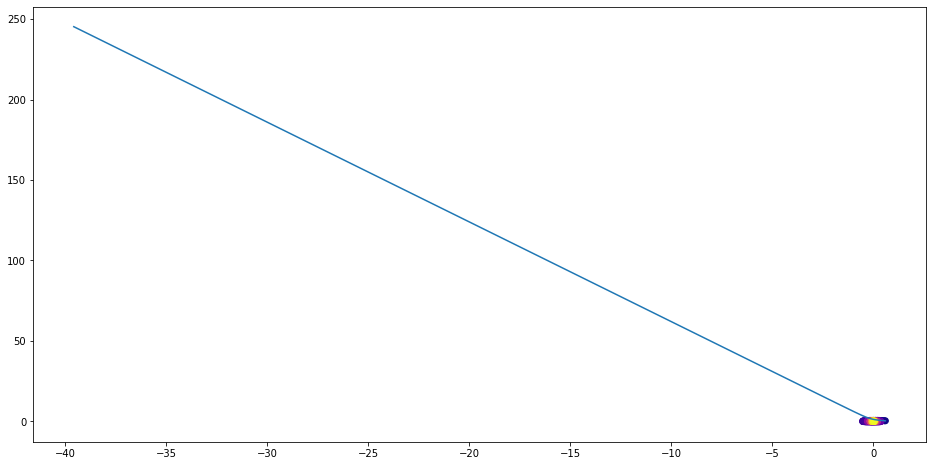

In [10]:
conduct_experiment(ode_true, ode_trained, 500, "linear")

In [11]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

FileNotFoundError: [Errno 2] No such file or directory: 'assets/imgs/comp/0.png'

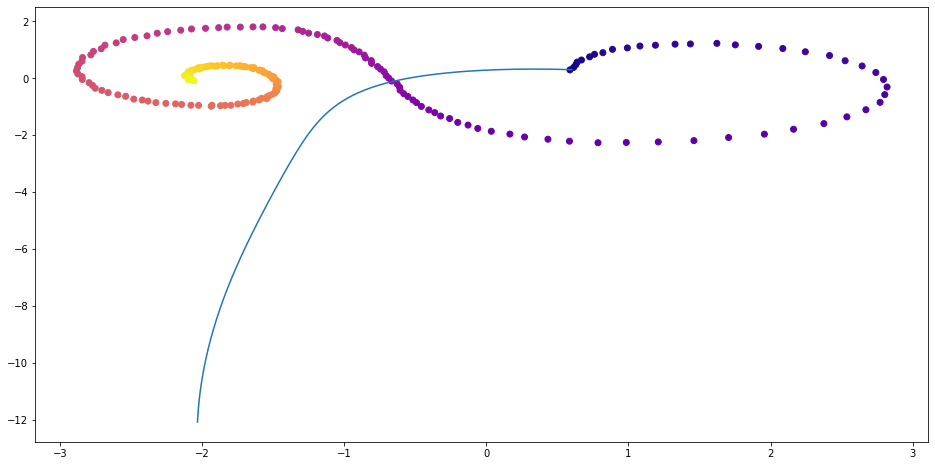

In [12]:
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)